In [1]:
import sys
import yaml
import phate
import torch
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import scipy
import numpy as np
from math import pi
import matplotlib.pyplot as plt


sys.path.append("../")
from src.models.lit_encoder import LitAutoencoder
from src.data.make_dataset import train_dataloader
from src.models.lit_node import NODE, ToyODE

/home/mila/g/guillaume.huguet/.conda/envs/phate_fim/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Test on a sphere

In [6]:
def sphere_metric(theta, phi):
    return torch.tensor([[1, 0], [0, torch.sin(theta) ** 2]])


def polar_to_euc(mat):
    """mat (np.array): N X D
    N: number of observation in the path
    D: dimension (theta,psi)"""
    N, D = mat.shape
    coor = np.empty((N, 3))
    for i in range(N):
        theta, psi = mat[i, :]
        coor[i, :] = (
            np.sin(theta) * np.cos(psi),
            np.sin(theta) * np.sin(psi),
            np.cos(theta),
        )

    return coor

In [22]:
fn_ode = ToyODE(2, [20, 10, 10])
neural_ode = NODE(fn_ode, method="rk4")

In [23]:
x0 = torch.tensor([0.0, 0.0]).view(1, 2)
x1 = torch.tensor([pi, 0.0]).view(1, 2)

In [24]:
n_epochs = 1000
n_steps = 10
optimizer = torch.optim.AdamW(params=neural_ode.parameters(), lr=0.0001)

In [25]:
neural_ode.train()
for epoch in range(n_epochs):

    optimizer.zero_grad()

    path = neural_ode(x0, n_steps).squeeze(1)

    x1_pred = path[-1]

    pred_loss = torch.nn.MSELoss()(x1_pred, x1)
    cost = []
    for idx, p in enumerate(path):
        t = torch.tensor([idx+1])
        c = torch.sqrt(neural_ode.fn_ode(t,p.view(1,2)) @ sphere_metric(*p) @ neural_ode.fn_ode(t,p.view(1,2)).T)
        cost.append(c)
    #cost = [torch.sqrt(neural_ode.fn_ode(t,p.view(1,2)) @ sphere_metric(*p) @ neural_ode.fn_ode(t,p.view(1,2))) for p in path]
    loss = sum(cost) / len(cost) + pred_loss

    if epoch % 100 == 0:
        print(loss)

    loss.backward()
    optimizer.step()

tensor([[15.5748]], grad_fn=<AddBackward0>)
tensor([[8.6602]], grad_fn=<AddBackward0>)
tensor([[4.3354]], grad_fn=<AddBackward0>)
tensor([[1.6752]], grad_fn=<AddBackward0>)
tensor([[0.6510]], grad_fn=<AddBackward0>)
tensor([[0.4834]], grad_fn=<AddBackward0>)
tensor([[0.4659]], grad_fn=<AddBackward0>)
tensor([[0.4638]], grad_fn=<AddBackward0>)
tensor([[0.4626]], grad_fn=<AddBackward0>)
tensor([[0.4614]], grad_fn=<AddBackward0>)


In [26]:
path = neural_ode(x0, n_steps).squeeze(1)
path_euc = polar_to_euc(path.detach().numpy())

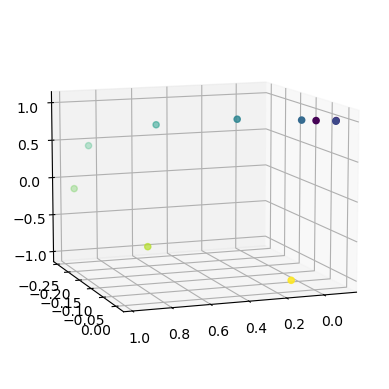

In [29]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(path_euc[:, 0], path_euc[:, 1], path_euc[:, 2], c=list(range(n_steps)))
ax.view_init(10, 70)
plt.show()

In [30]:
# Without the metric loss.
fn_ode = ToyODE(2, [5, 5])
neural_ode = NODE(fn_ode, method="rk4")

n_epochs = 1000
n_steps = 10
optimizer = torch.optim.AdamW(params=neural_ode.parameters(), lr=0.0001)

neural_ode.train()
for epoch in range(n_epochs):
    optimizer.zero_grad()

    path = neural_ode(x0, n_steps).squeeze(1)

    x1_pred = path[-1]

    pred_loss = torch.nn.MSELoss()(x1_pred, x1)
    loss = pred_loss

    if epoch % 20 == 0:
        print(loss)

    loss.backward()
    optimizer.step()

tensor(17.9958, grad_fn=<MseLossBackward0>)
tensor(17.3451, grad_fn=<MseLossBackward0>)
tensor(16.7266, grad_fn=<MseLossBackward0>)
tensor(16.1471, grad_fn=<MseLossBackward0>)
tensor(15.5994, grad_fn=<MseLossBackward0>)
tensor(15.0827, grad_fn=<MseLossBackward0>)
tensor(14.5911, grad_fn=<MseLossBackward0>)
tensor(14.1164, grad_fn=<MseLossBackward0>)
tensor(13.6650, grad_fn=<MseLossBackward0>)
tensor(13.2320, grad_fn=<MseLossBackward0>)
tensor(12.8169, grad_fn=<MseLossBackward0>)
tensor(12.4175, grad_fn=<MseLossBackward0>)
tensor(12.0284, grad_fn=<MseLossBackward0>)
tensor(11.6444, grad_fn=<MseLossBackward0>)
tensor(11.2675, grad_fn=<MseLossBackward0>)
tensor(10.8894, grad_fn=<MseLossBackward0>)
tensor(10.5248, grad_fn=<MseLossBackward0>)
tensor(10.1792, grad_fn=<MseLossBackward0>)
tensor(9.8529, grad_fn=<MseLossBackward0>)
tensor(9.5449, grad_fn=<MseLossBackward0>)
tensor(9.2541, grad_fn=<MseLossBackward0>)
tensor(8.9743, grad_fn=<MseLossBackward0>)
tensor(8.7016, grad_fn=<MseLossBackw

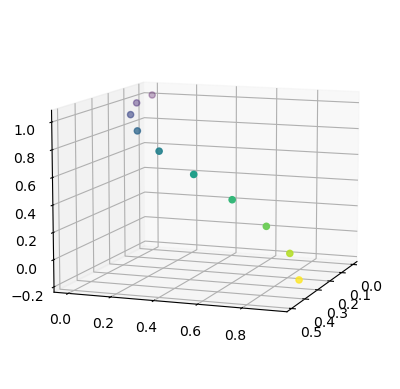

In [31]:
path = neural_ode(x0, n_steps).squeeze(1)
path_euc = polar_to_euc(path.detach().numpy())

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(path_euc[:, 0], path_euc[:, 1], path_euc[:, 2], c=list(range(n_steps)))
ax.view_init(10, 20)
plt.show()